$$
t_{\alpha\beta}\left(\theta_{t},\phi_{t},\theta_{i}\right)=\frac{k_{t}^{2}}{\cos\theta_{i}}\left|N_{\alpha\beta}\right|^{2}\frac{\eta_{i}}{\eta_{t}}\frac{1}{2H}S\\

S = \sum_{n=0}^{\infty}\frac{\left(-1\right)^{n}}{2^{2n}\left(n!\right)^{2}}\frac{\left(\eta_{xy}\right)^{2n}}{\left(\frac{1}{2}\eta_{z}^{2}\sigma_{h}^{2}\right)^{\frac{n+1}{H}}}\Gamma\left(\frac{n+1}{H}\right)\\

S=\sum_{n=0}^{\infty}\left(-1\right)^{n}\exp\left(-2n\ln2-2\ln\left(n\right)-2\ln\left(n-1\right)!+2n\ln\left(\eta_{xy}\right)-\frac{n+1}{H}\ln\left(\frac{1}{2}\eta_{z}^{2}\sigma_{h}^{2}\right)+\ln\left(\Gamma\left(\frac{n+1}{H}\right)\right)\right)\\

\eta_{xy}=\sqrt{\left(k_{t}\sin\theta_{t}\cos\phi_{t}-k_{i}\sin\theta_{i}\right)^{2}+\left(k_{t}\sin\theta_{t}\sin\phi_{t}\right)^{2}}\\

\eta_{z}=k_{i}\cos\theta_{i}-k_{t}\cos\theta_{t}\\

k_{i,t}=\frac{2\pi f}{\sqrt{\mu_{0}\epsilon_{0}\epsilon_{i,t}^{\prime}}}\\

\eta_{t}=\sqrt{\frac{\mu_{0}}{\epsilon_{s}^{\prime}\epsilon_{0}}}\\

\eta_{i}=\sqrt{\frac{\mu_{0}}{\epsilon_{0}}}\\

N_{hh}=\left[\left(1+R_{h}\right)\cos\theta_{t}+\frac{\eta_{t}}{\eta_{i}}\left(1-R_{h}\right)\cos\theta_{i}\right]\cos\phi_{t}\\

N_{hv}=\left[-\left(1+R_{h}\right)-\frac{\eta_{t}}{\eta_{i}}\left(1-R_{h}\right)\cos\theta_{i}\cos\theta_{t}\right]\sin\phi_{t}\\

N_{vh}=\left[\frac{\eta_{t}}{\eta_{i}}\left(1+R_{v}\right)-\left(1-R_{v}\right)\cos\theta_{i}\cos\theta_{t}\right]\sin\phi_{t}\\

N_{vv}=\left[\frac{\eta_{t}}{\eta_{i}}\left(1+R_{v}\right)\cos\theta_{t}+\left(1-R_{v}\right)\cos\theta_{i}\right]\cos\phi_{t}\\

R_{v}\left(\theta_{i}\right)=\frac{n_{i}\cos\theta_{i}-n_{t}\sqrt{1-\left(\frac{n_{i}}{n_{t}}\sin\theta_{i}\right)^{2}}}{n_{i}\cos\theta_{i}+n_{t}\sqrt{1-\left(\frac{n_{1}}{n_{t}}\sin\theta_{i}\right)^{2}}}\\
R_{h}\left(\theta_{i}\right)=\frac{n_{i}\sqrt{1-\left(\frac{n_{i}}{n_{t}}\sin\theta_{i}\right)^{2}}-n_{2}\cos\theta_{i}}{n_{i}\sqrt{1-\left(\frac{n_{i}}{n_{t}}\sin\theta_{i}\right)^{2}}+n_{2}\cos\theta_{i}}\\
n_{t}=\sqrt{\epsilon_{s}^{\prime}\epsilon_{0}\mu_{0}}\\
n_{i}=\sqrt{\epsilon_{0}\mu_{0}}\\
$$

In [3]:
import numpy as np
from scipy.constants import (
    epsilon_0,   # Permittivity of free space (vacuum)
    mu_0,        # Permeability of free space (vacuum)
    c,           # Speed of light in vacuum
)
from scipy.special import loggamma, factorial, gamma
from decimal import Decimal
import decimal

def transmissivity_fBm(
        f, epsilon_i_prime, epsilon_t_prime, sigma_A, H, 
        theta_i, theta_t, phi_t, bistatic_polarization,
        tolerance = 1e-5,
        decimal_precision = int(1e3),
        max_n_convergence = 10.0,
        debug = False
        ):
    
    # Evaluate constants
    omega = 2 * np.pi * f

    lambda_i = c / (f * np.sqrt(epsilon_i_prime)) 
    lambda_t = c / (f * np.sqrt(epsilon_t_prime)) 
    k_i = 2 * np.pi / lambda_i
    k_t = 2 * np.pi / lambda_t

    eta_xy = np.sqrt((k_t * np.sin(theta_t) * np.cos(phi_t) - k_i * np.sin(theta_i))**2 \
                    + (k_t * np.sin(theta_t) * np.sin(phi_t))**2)
    eta_z = k_i * np.cos(theta_i) - k_t * np.cos(theta_t)

    # Evaluate the series S at 0
    n = 0

    first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
    second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_A**2)**((n+1)/H)
    third_factor = gamma((n + 1) / H)

    sum = Decimal(first_fraction*second_fraction*third_factor)
    delta_sum_list = [np.log(first_fraction*second_fraction*third_factor)]
    old_log_factorial = np.log(factorial(n))
    accuracy_overflow = False

    # Evaluate the series S from 1 to max_n_convergence
    # or until the terms is less than tolerance
    for n in np.arange(1.0, max_n_convergence + 1.0, 1):

        new_log_factorial = 2 * np.log(n) + old_log_factorial
        old_log_factorial = new_log_factorial
        kernel =  -2 * n * np.log(2) \
            - new_log_factorial \
                + 2 * n * np.log(eta_xy) \
                    - ((n+1) / H)*np.log(0.5 * eta_z**2 * sigma_A**2) \
                        + loggamma((n + 1) / H)
        
        delta_sum = Decimal(np.e)**Decimal(kernel)
        sum += Decimal((-1**n)) * delta_sum
        delta_sum_list.append(kernel)

        if kernel > decimal_precision :
            accuracy_overflow = True

        if n != 0:   
            if tolerance > delta_sum:
                break
    
    # Mask the sum if it exceeded the max n convergence, 
    # or if the decimal precision was not high enough
    terms_to_converge = n

    if terms_to_converge >= max_n_convergence:
        sum = np.nan
        
    if accuracy_overflow:
        sum[i] = np.nan

    ## Calculate the transmissivity
    eta_i = np.sqrt(mu_0 / (epsilon_i_prime * epsilon_0))
    eta_t = np.sqrt(mu_0 / (epsilon_t_prime * epsilon_0))
    n_i = np.sqrt(epsilon_i_prime * epsilon_0 * mu_0)
    n_t = np.sqrt(epsilon_t_prime * epsilon_0 * mu_0)

    R_v = (n_i * np.cos(theta_i) - n_t * np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2)) \
        / (n_i * np.cos(theta_i) + n_t * np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2))

    R_h = (n_i * np.sqrt(1 - (n_i * np.sin(theta_i) / n_t)**2) - n_t * np.cos(theta_i)) \
        / (n_i * np.sqrt(1 - (n_i * np.sin(theta_i) / n_t)**2) + n_t * np.cos(theta_i))

    if bistatic_polarization == 'hh':
        N_ab = ((1 + R_h) * np.cos(theta_t) + (eta_t / eta_i) * (1 - R_h) * np.cos(theta_i)) * np.cos(phi_t)
    elif bistatic_polarization == 'hv':
        N_ab = (-1 * (1 + R_h) - (eta_t / eta_i) * (1 - R_h) * np.cos(theta_i) * np.cos(theta_t)) * np.sin(phi_t)
    elif bistatic_polarization == 'vh':
        N_ab = ((eta_t / eta_i) * (1 + R_v) - (1 - R_v) * np.cos(theta_i) * np.cos(theta_t)) * np.sin(phi_t)
    elif bistatic_polarization == 'vv':
        N_ab = ((eta_t / eta_i) * (1 + R_v) + (1 - R_v) * np.cos(theta_i))
    else:
        raise(ValueError('bistatic polarization must be \'vv\',  \'vh\',  \'hv\',  or \'hh\''))

    t_ab = (k_t**2 / np.cos(theta_i)) * (eta_i / eta_t) * np.abs(N_ab)**2 * (1 / (2*H)) * float(sum)

    if debug:
        return t_ab, sum, terms_to_converge, accuracy_overflow
    else:
        return t_ab
    
transmissivity_fBm(
    f = 5.373e6, # Hz
    epsilon_i_prime = 1,
    epsilon_t_prime = 3.14,
    sigma_A = 0.2 * (3e8/5.373e6)**(0.75), # m
    H = 0.75,
    theta_i = np.pi / 4,
    phi_t = np.pi/200,
    theta_t = np.pi - np.arcsin(np.sin(np.pi / 4)/np.sqrt(3.14)),
    bistatic_polarization='vv'
)

0.21877732235104183

In [1]:
0.2 * (3e8/5.373e6)**(0.75)

4.085152808149336

In [ ]:
sum = Decimal('5816.992566008816538669634610')
bistatic_polarization = 'hh'

f = 5.373e6 # Hz
epsilon_i_prime = 1
epsilon_t_prime = 3.14
sigma_h = 20 # m
H = 0.75
theta_i = np.pi / 4
phi_t = 0
theta_t = np.pi - np.arcsin(np.sin(np.pi / 4)/np.sqrt(3.14))
bistatic_polarization='vh'

lambda_i = c / (f * np.sqrt(epsilon_i_prime)) 
lambda_t = c / (f * np.sqrt(epsilon_t_prime)) 
k_i = 2 * np.pi / lambda_i
k_t = 2 * np.pi / lambda_t

eta_i = np.sqrt(mu_0 / (epsilon_i_prime * epsilon_0))
eta_t = np.sqrt(mu_0 / (epsilon_t_prime * epsilon_0))
n_i = np.sqrt(epsilon_i_prime * epsilon_0 * mu_0)
n_t = np.sqrt(epsilon_t_prime * epsilon_0 * mu_0)

R_v = (n_i * np.cos(theta_i) - n_t * np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2)) \
    / (n_i * np.cos(theta_i) + n_t * np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2))

R_h = (n_i * np.sqrt(1 - (n_i * np.sin(theta_i) / n_t)**2) - n_t * np.cos(theta_i)) \
    / (n_i * np.sqrt(1 - (n_i * np.sin(theta_i) / n_t)**2) + n_t * np.cos(theta_i))

if bistatic_polarization == 'hh':
    N_ab = ((1 + R_h) * np.cos(theta_t) + (eta_t / eta_i) * (1 - R_h) * np.cos(theta_i)) * np.cos(phi_t)
elif bistatic_polarization == 'hv':
    N_ab = (-1 * (1 + R_h) - (eta_t / eta_i) * (1 - R_h) * np.cos(theta_i) * np.cos(theta_t)) * np.sin(phi_t)
elif bistatic_polarization == 'vh':
    N_ab = ((eta_t / eta_i) * (1 + R_v) - (1 - R_v) * np.cos(theta_i) * np.cos(theta_t)) * np.sin(phi_t)
elif bistatic_polarization == 'vv':
    N_ab = ((eta_t / eta_i) * (1 + R_v) + (1 - R_v) * np.cos(theta_i))
else:
    raise(ValueError('bistatic polarization must be \'vv\',  \'vh\',  \'hv\',  or \'hh\''))

(k_t**2 / np.cos(theta_i)) * (eta_i / eta_t) * np.abs(N_ab)**2 * (1 / (2*H)) * float(sum)

In [2]:
# Imports and plotting setups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math

import sys, os
sys.path.insert(0, '../../')
sys.path.insert(0, '../')

import math_funcs

from cycler import cycler

default_cycler = (cycler(color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', 'black']) +
                cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':']))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 8

plt.rcParams['figure.figsize'] = (3.5, 2.5)
plt.rcParams['figure.dpi'] = 200

plt.rcParams['text.usetex'] = True

from scipy.constants import (
    epsilon_0,   # Permittivity of free space (vacuum)
    mu_0,        # Permeability of free space (vacuum)
    c,           # Speed of light in vacuum
    #e,           # Elementary charge
    #h,           # Planck constant
    #hbar,        # Reduced Planck constant (h-bar)
    k,           # Boltzmann constant
    #G,           # Newtonian constant of gravitation
    #m_e,         # Electron mass
    #m_p,         # Proton mass
    #m_n,         # Neutron mass
    #alpha,       # Fine-structure constant
    eV,          # Electron volt
)

# Example usage of some constants
print(f"Permittivity of free space: {epsilon_0} F/m")
print(f"Permeability of free space: {mu_0} N/A^2")
print(f"Speed of light in vacuum: {c} m/s")
# print(f"Elementary charge: {e} C")
# print(f"Planck constant: {h} J·s")
# print(f"Reduced Planck constant: {hbar} J·s")
print(f"Boltzmann constant: {k} J/K")
# print(f"Newtonian constant of gravitation: {G} m^3/kg/s^2")
# print(f"Electron mass: {m_e} kg")
# print(f"Proton mass: {m_p} kg")
# print(f"Neutron mass: {m_n} kg")
# print(f"Fine-structure constant: {alpha}")
print(f"Electron volt: {eV} J")

def print_engineering_notation(value):
    """
    Print a value in engineering notation (powers of ten in multiples of 3).

    Parameters:
    value (float): The value to be printed in engineering notation.
    """
    
    if value == 0:
        print("0")
        return

    exponent = int(math.floor(math.log10(abs(value)) / 3) * 3)
    mantissa = value / (10 ** exponent)
    
    print(f"{mantissa:.3f}e{exponent}")

# Example usage
print_engineering_notation(0)          # Output: 0
print_engineering_notation(1234.56)    # Output: 1.235e3
print_engineering_notation(0.00123456) # Output: 1.235e-3
print_engineering_notation(-987654)    # Output: -987.654e3
print_engineering_notation(1e9)        # Output: 1.000e9

Permittivity of free space: 8.8541878128e-12 F/m
Permeability of free space: 1.25663706212e-06 N/A^2
Speed of light in vacuum: 299792458.0 m/s
Boltzmann constant: 1.380649e-23 J/K
Electron volt: 1.602176634e-19 J
0
1.235e3
1.235e-3
-987.654e3
1.000e9


$$
S = \sum_{n=0}^{\infty}\frac{\left(-1\right)^{n}}{2^{2n}\left(n!\right)^{2}}\frac{\left(\eta_{xy}\right)^{2n}}{\left(\frac{1}{2}\eta_{z}^{2}\sigma_{h}^{2}\right)^{\frac{n+1}{H}}}\Gamma\left(\frac{n+1}{H}\right)
$$

$$
\eta_{xy}=\sqrt{\left(k_{t}\sin\theta_{t}\cos\phi_{t}-k_{i}\sin\theta_{i}\right)^{2}+\left(k_{t}\sin\theta_{t}\sin\phi_{t}\right)^{2}}
$$

$$
\eta_{z}=k_{i}\cos\theta_{i}-k_{t}\cos\theta_{t}
$$

$$
k_{i,t}=\frac{2\pi f}{\sqrt{\mu_{0}\epsilon_{0}\epsilon_{i,t}^{\prime}}}
$$

In [20]:
from scipy.special import gamma
from scipy.special import factorial

# Calculations of the convergence of the above series (S)
tolerance = 1e-5

f = 5.373e6 # Hz
omega = 2 * np.pi * f
epsilon_i_prime = 1
epsilon_t_prime = 3.14
sigma_h = 0.2 # m
H = 0.75

theta_i = np.pi / 4 #np.linspace(0, np.pi, 10)
theta_t = np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)) + 14 * np.pi / 400 #np.linspace(0, np.pi, 10)
phi_t = 0 #np.linspace(0, 2*np.pi, 10)

lambda_i = c / (f * np.sqrt(epsilon_i_prime)) 
lambda_t = c / (f * np.sqrt(epsilon_t_prime)) 
k_i = 2 * np.pi / lambda_i
k_t = 2 * np.pi / lambda_t

eta_xy = np.sqrt((k_t * np.sin(theta_t) * np.cos(phi_t) - k_i * np.sin(theta_i))**2 \
                 + (k_t * np.sin(theta_t) * np.sin(phi_t))**2)
eta_z = k_i * np.cos(theta_i) - k_t * np.cos(theta_t)

sum = 0
delta_sum_list = []

for n in np.arange(0,1000, 1):
    first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
    second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
    third_factor = gamma((n + 1) / H)

    kernel = first_fraction*second_fraction*third_factor
    sum += kernel
    delta_sum_list.append(kernel)
    
    if n != 0:   
        if tolerance > np.abs(kernel):
            break

display(sum, delta_sum_list)

C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_920\543507895.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_920\543507895.py:36: RuntimeWarning: invalid value encountered in scalar add
  sum += kernel
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_920\543507895.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_920\543507895.py:32: RuntimeWarning: invalid value encountered in scalar divide
  second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_920\543507895.py:31: RuntimeWarning: overflow encountered in scalar power
  first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_920\5435078

nan

[5389.091025606395,
 -5790.292696176196,
 3681.2075597646035,
 -1744.4836987210476,
 674.0469949936113,
 -222.74328630995714,
 64.8474958485069,
 -16.972009978506126,
 4.05218049741744,
 -0.8924523077137299,
 0.18289687075332875,
 -0.035123664348175855,
 0.006357290051190749,
 -0.001089734322752138,
 0.00017763440786492296,
 -2.7632686358496177e-05,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 n

$$
S = \sum_{n=0}^{\infty}\frac{\left(-1\right)^{n}}{2^{2n}\left(n!\right)^{2}}\frac{\left(\eta_{xy}\right)^{2n}}{\left(\frac{1}{2}\eta_{z}^{2}\sigma_{h}^{2}\right)^{\frac{n+1}{H}}}\Gamma\left(\frac{n+1}{H}\right)
$$

$$
S=\sum_{n=0}^{\infty}\left(-1\right)^{n}\exp\left(2n\ln2-2\ln\left(n\right)-2\ln\left(n-1\right)!+2n\ln\left(\eta_{xy}\right)-\frac{n+1}{H}\ln\left(\frac{1}{2}\eta_{z}^{2}\sigma_{h}^{2}\right)+\ln\left(\Gamma\left(\frac{n+1}{H}\right)\right)\right)
$$

$$
\eta_{xy}=\sqrt{\left(k_{t}\sin\theta_{t}\cos\phi_{t}-k_{i}\sin\theta_{i}\right)^{2}+\left(k_{t}\sin\theta_{t}\sin\phi_{t}\right)^{2}}
$$

$$
\eta_{z}=k_{i}\cos\theta_{i}-k_{t}\cos\theta_{t}
$$

$$
k_{i,t}=\frac{2\pi f}{\sqrt{\mu_{0}\epsilon_{0}\epsilon_{i,t}^{\prime}}}
$$

In [5]:
import numpy as np
from scipy.constants import (
    epsilon_0,   # Permittivity of free space (vacuum)
    mu_0,        # Permeability of free space (vacuum)
    c,           # Speed of light in vacuum
)
from scipy.special import loggamma, factorial, gamma
from decimal import Decimal
import decimal

def transmissivity_fBm(
        f, epsilon_i_prime, epsilon_t_prime, sigma_h, H, theta_i, theta_t, phi_t, 
        tolerance = 1e-5,
        decimal_precision = int(1e3),
        max_n_convergence = 10.0,
        debug = False
        ):
    
    # Evaluate constants
    omega = 2 * np.pi * f

    lambda_i = c / (f * np.sqrt(epsilon_i_prime)) 
    lambda_t = c / (f * np.sqrt(epsilon_t_prime)) 
    k_i = 2 * np.pi / lambda_i
    k_t = 2 * np.pi / lambda_t

    eta_xy = np.sqrt((k_t * np.sin(theta_t) * np.cos(phi_t) - k_i * np.sin(theta_i))**2 \
                    + (k_t * np.sin(theta_t) * np.sin(phi_t))**2)
    eta_z = k_i * np.cos(theta_i) - k_t * np.cos(theta_t)

    # Evaluate the series S at 0
    n = 0

    first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
    second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
    third_factor = gamma((n + 1) / H)

    sum = Decimal(first_fraction*second_fraction*third_factor)
    delta_sum_list = [np.log(first_fraction*second_fraction*third_factor)]
    old_log_factorial = np.log(factorial(n))
    accuracy_overflow = False

    # Evaluate the series S from 1 to max_n_convergence
    # or until the terms is less than tolerance
    for n in np.arange(1.0, max_n_convergence + 1.0, 1):

        new_log_factorial = 2 * np.log(n) + old_log_factorial
        old_log_factorial = new_log_factorial
        kernel =  2 * n * np.log(2) \
            - new_log_factorial \
                + 2 * n * np.log(eta_xy) \
                    - ((n+1) / H)*np.log(0.5 * eta_z**2 * sigma_h**2) \
                        + loggamma((n + 1) / H)
        
        delta_sum = Decimal(np.e)**Decimal(kernel)
        sum += Decimal((-1**n)) * delta_sum
        delta_sum_list.append(kernel)

        if kernel > decimal_precision :
            accuracy_overflow = True

        if n != 0:   
            if tolerance > delta_sum:
                break
    
    # Mask the sum if it exceeded the max n convergence, 
    # or if the decimal precision was not high enough
    terms_to_converge = n

    if terms_to_converge >= max_n_convergence:
        sum = np.nan
        
    if accuracy_overflow:
        sum[i] = np.nan

    if debug:
        return sum, terms_to_converge, accuracy_overflow
    else:
        return sum
    
transmissivity_fBm(
    f = 5.373e6, # Hz
    epsilon_i_prime = 1,
    epsilon_t_prime = 3.14,
    sigma_h = 0.2, # m
    H = 0.75,
    theta_i = np.pi / 4,
    phi_t = 0,
    theta_t = np.pi - np.arcsin(np.sin(np.pi / 4)/np.sqrt(3.14))
)

Decimal('5816.992566008816538669634610')

Decimal('3994.008872559393955386511094')

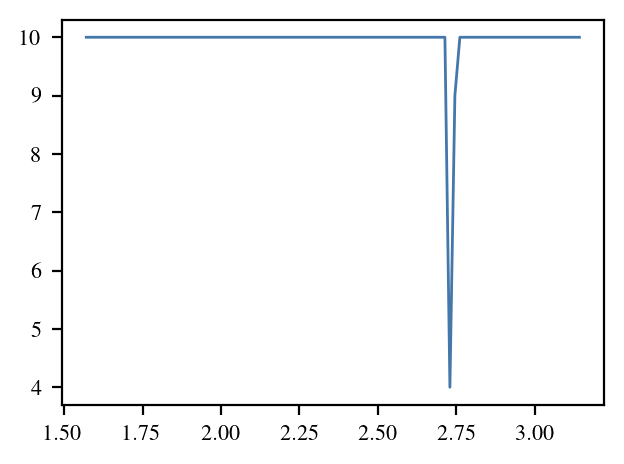

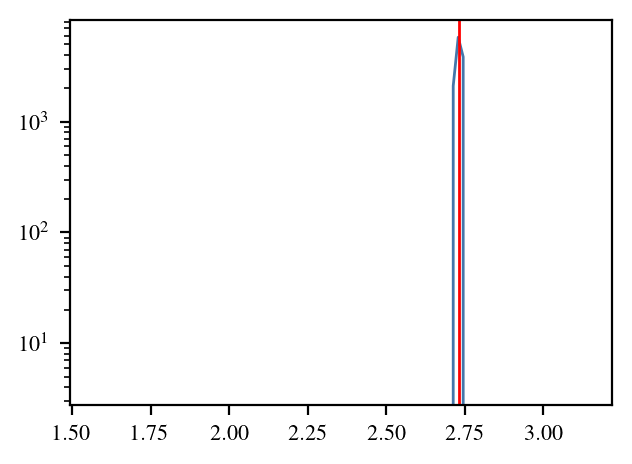

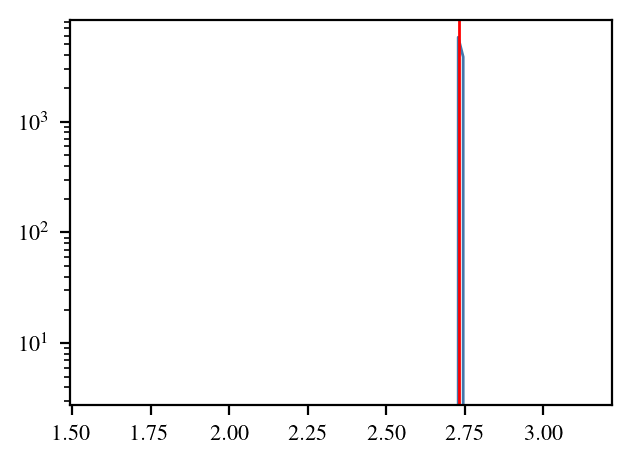

In [7]:
from scipy.special import loggamma, factorial, gamma
from decimal import Decimal
import decimal

# Calculations of the convergence of the above series (S)
tolerance = 1e-5

f = 5.373e6 # Hz
omega = 2 * np.pi * f
epsilon_i_prime = 1
epsilon_t_prime = 3.14
sigma_h = 0.2 # m
H = 0.75

decimal_precision = int(1e3)
decimal.getcontext().prec=decimal_precision
decimal.getcontext()

theta_i = np.pi / 4 
phi_t = 0 

max_n_convergence = 10.0

terms_to_converge = []
accuracy_overflow = []
sum_terms = []

lambda_i = c / (f * np.sqrt(epsilon_i_prime)) 
lambda_t = c / (f * np.sqrt(epsilon_t_prime)) 
k_i = 2 * np.pi / lambda_i
k_t = 2 * np.pi / lambda_t

theta_t_range = np.linspace(np.pi/2, np.pi, 100) #[np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)) + 5*np.pi/2/100]#
for theta_t in theta_t_range:

    eta_xy = np.sqrt((k_t * np.sin(theta_t) * np.cos(phi_t) - k_i * np.sin(theta_i))**2 \
                    + (k_t * np.sin(theta_t) * np.sin(phi_t))**2)
    eta_z = k_i * np.cos(theta_i) - k_t * np.cos(theta_t)

    n = 0

    first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
    second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
    third_factor = gamma((n + 1) / H)

    sum = Decimal(first_fraction*second_fraction*third_factor)
    delta_sum_list = [np.log(first_fraction*second_fraction*third_factor)]
    old_log_factorial = np.log(factorial(n))
    prec_over = False

    for n in np.arange(1.0, max_n_convergence + 1.0, 1):

        new_log_factorial = 2 * np.log(n) + old_log_factorial
        old_log_factorial = new_log_factorial
        kernel =  2 * n * np.log(2) \
            - new_log_factorial \
                + 2 * n * np.log(eta_xy) \
                    - ((n+1) / H)*np.log(0.5 * eta_z**2 * sigma_h**2) \
                        + loggamma((n + 1) / H)
        
        delta_sum = Decimal(np.e)**Decimal(kernel)
        sum += Decimal((-1**n)) * delta_sum
        delta_sum_list.append(kernel)

        if kernel > decimal_precision :
            prec_over = True

        if n != 0:   
            if tolerance > delta_sum:
                break
            
    terms_to_converge.append(n)
    sum_terms.append(sum)
    accuracy_overflow.append(prec_over)
    

#display(sum, np.max(delta_sum_list), np.argmax(delta_sum_list), np.min(delta_sum_list), np.argmin(delta_sum_list))

plt.figure()
plt.plot(theta_t_range, terms_to_converge)

plt.figure()
plt.plot(theta_t_range, sum_terms)
plt.yscale('log')
plt.vlines(np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)), 0, 1e4, colors='red')

remove_bad_terms = sum_terms.copy()

for i in range(len(remove_bad_terms)):
    if terms_to_converge[i] >= max_n_convergence:
        remove_bad_terms[i] = 0 
    
    if accuracy_overflow[i]:
        remove_bad_terms[i] = 0

plt.figure()
plt.plot(theta_t_range, remove_bad_terms)
plt.yscale('log')
plt.vlines(np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)), 0, 1e4, colors='red')

In [6]:
remove_bad_terms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 Decimal('5790.243566636031172121947523586801970163122692714589814297371347709255697520403140529044504137177537635923068865276642167659780012248820633753803778034109313705763617490888712522875915078202885174732568267633727817912428639778304904083335949854989121880883229312159448041684825837666865067212193699869396391455164305633644393167043723657547107632242692444980229350334675002220034339396001086426141168674665573729427643038185496825177856699536849761012566802956393500040820219053577121618884282269677502678678206217941584835239526595008980798156891715418084429271787195017520045386520310955880166674709314700536597709637278293648059274171604425585395543924347342676336904221012673785850116080506726

In [56]:
np.argmax(sum_terms)
i = 70
sum_terms[i], terms_to_converge[i], accuracy_overflow[i]

(Decimal('-762721.6349509384246652278184309496226227886162860164132100086069891320209264820146413225265670060021971663818081740482735218264715389317762656688974295080908273965351020623189748107441836525915957726161125831994404241027328180747849335668266410015590322892054212229926268652258512618280482256659005796284365692133857519865073843266306395242236774789067971355252262824753922649553472596053151647158852333010960768847869583378715064283789976077001606186885835324068621512790355949825487413480396943776694058140312178955209217877445447921182344080269795148578643895605976045468182448706511409119052889806739425427712777148837900116013390994291457734430321582799100312067885204824806897404721372606491418529135356183595285846695496426981438871431404442584479935128050834441076625262256578029047534477940156883879602178209376855360610296245860618489624381805882996688002435593352565342017397093774774023619088524619426693903006771622849061473001153844349182337250343181857102555294993541428659

In [44]:
remove_zero_value_sum_terms = sum_terms.copy()

for i in range(len(remove_zero_value_sum_terms)):
    if terms_to_converge[i] >= 9:
        remove_zero_value_sum_terms[i] = 0 

remove_zero_value_sum_terms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 Decimal('5790.243566636031172121947523586801970163122692714589814297371347709255697520403140529044504137177537635923068865276642167659780012248820633753803778034109313705763617490888712522875915078202885174732568267633727817912428639778304904083335949854989121880883229312159448041684825837666865067212193699869396391455164305633644393167043723657547107632242692444980229350334675002220034339396001086426141168674665573729427643038185496825177856699536849761012566802956393500040820219053577121618884282269677502678678206217941584835239526595008980798156891715418084429271787195017520045386520310955880166674709314700536597709637278293648059274171604425585395543924347342676336904221012673785850116080506726

In [3]:
# For reflected case

theta_i = np.pi / 4 #np.linspace(0, np.pi, 10)
theta_s = np.pi / 3 #np.linspace(0, np.pi, 10)
phi_s = 0 #np.linspace(0, 2*np.pi, 10)

eta_x = k_i * (np.sin(theta_i) - np.sin(theta_s) * np.cos(phi_s))
eta_y = k_i * np.sin(theta_s) * np.sin(phi_s)
eta_z = k_i * (np.cos(theta_i) + np.cos(theta_s))

eta_xy = np.sqrt(eta_x**2 + eta_y**2)

sum = 0
delta_sum_list = []

for n in np.arange(0,100, 1):
    first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
    second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
    third_factor = gamma((n + 1) / H)

    kernel = first_fraction*second_fraction*third_factor
    sum += kernel
    delta_sum_list.append(kernel)
    
    if n != 0:
        if tolerance > np.abs(kernel):
            pass #break

display(sum, delta_sum_list)

C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_15560\572695195.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_15560\572695195.py:22: RuntimeWarning: invalid value encountered in scalar add
  sum += kernel
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_15560\572695195.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_15560\572695195.py:18: RuntimeWarning: invalid value encountered in scalar divide
  second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_15560\572695195.py:17: RuntimeWarning: overflow encountered in scalar power
  first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_1

nan

[33672.62537187027,
 -171287.8488884356,
 515562.02549626847,
 -1156703.6603126356,
 2115972.160848716,
 -3310464.79556938,
 4562912.485656868,
 -5653882.595941303,
 6390971.309903461,
 -6663887.874884411,
 6465669.741214022,
 -5878569.257275732,
 5037423.05785896,
 -4088100.9102897984,
 3154951.21722587,
 -2323556.523832836,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 -inf,
 inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [26]:
plt.figure()
plt.plot(theta_range, map(abs, sum_terms))
plt.yscale('log')
plt.vlines(np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)), 0, 1e4, colors='red')
sum_terms

c:\Users\Jake Sahli\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\units.py:156: RuntimeWarning: overflow encountered in cast
  return np.asarray(value, dtype=float)


[Decimal('-1.232424970831509717145606859E+17453'),
 Decimal('-5.294270837670257518182674843E+16999'),
 Decimal('-5.903606680966646406947645425E+16559'),
 Decimal('-1.239084711665860263312951102E+16132'),
 Decimal('-4.594701862501034358683847115E+15715'),
 Decimal('-3.531046641452537172816454438E+15309'),
 Decimal('-8.004098893217417255793836865E+14912'),
 Decimal('-9.011941135765955657052074970E+14524'),
 Decimal('-9.829461073732739501194650141E+14144'),
 Decimal('-2.303390923796638251197698070E+13772'),
 Decimal('-2.878725172323478404286408469E+13406'),
 Decimal('-5.258820671307048318271350347E+13046'),
 Decimal('-4.198494380728051098042049030E+12692'),
 Decimal('-4.728501005352606509447373099E+12343'),
 Decimal('-2.593666371137278023924836446E+11999'),
 Decimal('-2.537838761543868731283383076E+11659'),
 Decimal('-1.708636743654909879634687556E+11323'),
 Decimal('-3.194204206508308283257107761E+10990'),
 Decimal('-6.958523171467546647381493477E+10660'),
 Decimal('-7.668059596412998205

c:\Users\Jake Sahli\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\ticker.py:2392: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


Error in callback <function _draw_all_if_interactive at 0x000001DC832FF060> (for post_execute):


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

<Figure size 700x500 with 1 Axes>

In [ ]:
# For reflected loggamma derivation

theta_i = np.pi / 4 #np.linspace(0, np.pi, 10)
theta_s = np.pi / 5 #np.linspace(0, np.pi, 10)
phi_s = 0 #np.linspace(0, 2*np.pi, 10)

eta_x = k_i * (np.sin(theta_i) - np.sin(theta_s) * np.cos(phi_s))
eta_y = k_i * np.sin(theta_s) * np.sin(phi_s)
eta_z = k_i * (np.cos(theta_i) + np.cos(theta_s))

eta_xy = np.sqrt(eta_x**2 + eta_y**2)

n = 0

first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_h**2)**((n+1)/H)
third_factor = gamma((n + 1) / H)

sum = first_fraction*second_fraction*third_factor
delta_sum_list = [np.log(sum)]
old_log_factorial = factorial(0)

for n in np.arange(1,1000, 1):

    new_log_factorial = 2 * np.log(n) + old_log_factorial
    old_log_factorial = new_log_factorial
    kernel =  2 * n * np.log(2) \
        - new_log_factorial \
            + 2 * n * np.log(eta_xy) \
                - ((n+1) / H)*np.log(0.5 * eta_z**2 * sigma_h**2) \
                    + loggamma((n + 1) / H)
    
    sum += (-1**n) * np.e**kernel
    delta_sum_list.append(kernel)
    
    if n != 0:   
        if tolerance > np.abs(kernel):
            pass #break

display(sum, delta_sum_list)


-3.813406474474909e+20

[8.29099535330708,
 10.127881029041552,
 12.440018589533148,
 14.458315950375654,
 16.27248143138924,
 17.93028108649265,
 19.461379019338207,
 20.8859858023393,
 22.218754980941043,
 23.47079721001011,
 24.650826143932843,
 25.765858362217127,
 26.821665018150384,
 27.823076313339527,
 28.77419422141248,
 29.67854559521988,
 30.53919517190051,
 31.358830796747277,
 32.13982890767786,
 32.88430568183204,
 33.594157564322416,
 34.271093798192,
 34.916662835910614,
 35.532274006175925,
 36.11921545558354,
 36.67866913267524,
 37.21172339963876,
 37.71938372324831,
 38.20258179727524,
 38.66218337382942,
 39.09899502421531,
 39.513770006154985,
 39.90721338029691,
 40.27998649234749,
 40.63271091618395,
 40.96597193660688,
 41.28032163700661,
 41.576281646421336,
 41.85434559169073,
 42.11498129324093,
 42.35863273715236,
 42.58572185129168,
 42.796650109251885,
 42.9917999824728,
 43.17153625808942,
 43.336207237676376,
 43.486145830045245,
 43.62167054954884,
 43.74308642988501,
 43.850

In [ ]:
eta_xy, eta_z

(0.2207267361157228, 0.061472496125970236)

$$
\frac{\eta_{xy}^H}{|\eta_z|\sigma_h} \ll 1, \mathscr{\mathfrak{R}}\left\{ \frac{1}{2}\eta_{z}^{2}\sigma_{h}^{2}\right\} >0\text{,}\mathscr{\mathfrak{R}}\left\{ 2H\right\} >0
$$

In [ ]:
# Convergence check 6.15 from Franceschetti and Riccio 2007

eta_xy**H / (np.abs(eta_z)*sigma_h), 0.5 * eta_z**2 * sigma_h**2, 2 * H

(0.20954291750211365, 0.0016230877428847783, 1.5)

$$
\eta_z^2\sigma_h^2l^{2H}\gg1
$$

In [ ]:
# Convergence check 6.10 from Franceschetti and Riccio 2007

eta_z**2 * sigma_h**2

0.0032461754857695565

$$
\sum_{m=1}^{\infty}\frac{\left(k_{tdz}^{2}\sigma_{h}^{2}\right)^{m}}{m!m}l^{2}\exp\left(-\frac{k_{tdxy}^{2}l^{2}}{4m}\right)\exp\left(\sigma_{h}^{2}k_{tdz}^{2}\right)
$$

$$
\sum_{m=1}^{\infty}\frac{1}{m!}\exp\left(\ln\left(\frac{l^{2}}{m}\right)\right)\exp\left(m\ln\left(k_{tdz}^{2}\sigma_{h}^{2}\right)\right)\exp\left(-\frac{k_{tdxy}^{2}l^{2}}{4m}\right)\exp\left(\sigma_{h}^{2}k_{tdz}^{2}\right)
$$

0.41047339338420374

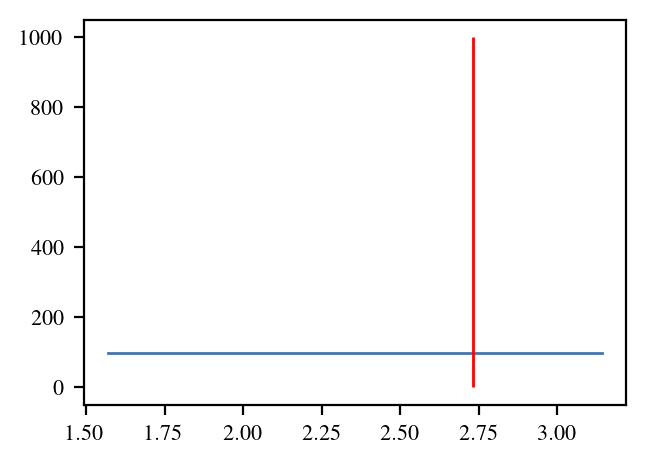

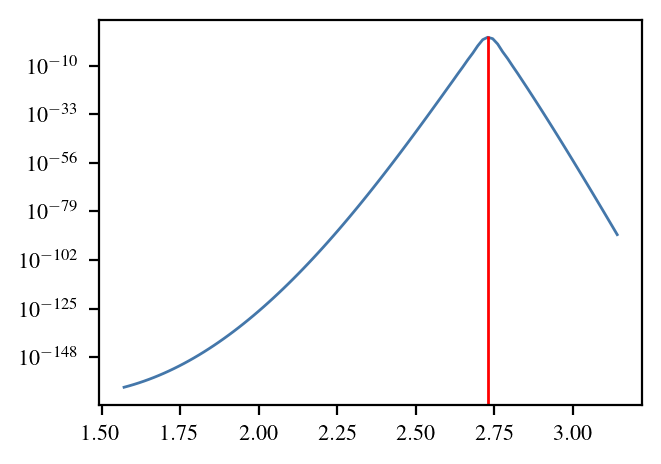

In [32]:
from scipy.special import loggamma
from decimal import Decimal
import decimal

decimal.getcontext().prec=int(1e2)
decimal.getcontext()

l = 1000 # m
theta_i = np.pi / 4 #np.linspace(0, np.pi, 10)
theta_t = np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)) #np.linspace(0, np.pi, 10)
display(theta_t)
phi_t = 0 #np.linspace(0, 2*np.pi, 10)

terms_to_converge = []
sum_terms = []
theta_range = np.linspace(np.pi/2, np.pi, 100) #[np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime))  ]#np.linspace(np.pi/2, np.pi, 100) #[np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)) + 5*np.pi/2/100]#
for theta_t in theta_range:
    lambda_i = c / (f * np.sqrt(epsilon_i_prime)) 
    lambda_t = c / (f * np.sqrt(epsilon_t_prime)) 
    k_i = 2 * np.pi / lambda_i
    k_t = 2 * np.pi / lambda_t

    eta_xy = np.sqrt((k_t * np.sin(theta_t) * np.cos(phi_t) - k_i * np.sin(theta_i))**2 \
                    + (k_t * np.sin(theta_t) * np.sin(phi_t))**2)
    eta_z = k_i * np.cos(theta_i) - k_t * np.cos(theta_t)

    sum = 0
    delta_sum_list = []
    old_log_factorial = np.log(factorial(0))

    for n in np.arange(1,1e2, 1):

        new_log_factorial = np.log(n) + old_log_factorial
        old_log_factorial = new_log_factorial
        kernel =  -1 * new_log_factorial + np.log(l**2 / n) \
            + n * np.log(eta_z**2 * sigma_h**2) \
                - eta_xy **2 * l**2 / (4 * n) \
                    + sigma_h**2 * eta_z**2
        #display(kernel)
        delta_sum = Decimal(np.e)**Decimal(kernel)
        sum += delta_sum
        delta_sum_list.append(kernel)

        # if n != 0:   
        #     if tolerance > delta_sum:
        #         break
    
    terms_to_converge.append(n)
    sum_terms.append(sum)
#display(sum, np.max(delta_sum_list), np.argmax(delta_sum_list), np.min(delta_sum_list), np.argmin(delta_sum_list))

plt.figure()
plt.plot(theta_range, terms_to_converge)
plt.vlines(np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)), 0, 1e3, colors='red')

plt.figure()
plt.plot(theta_range, sum_terms)
plt.yscale('log')
plt.vlines(np.pi - np.arcsin(np.sin(theta_i)/np.sqrt(epsilon_t_prime)), 0, 1e4, colors='red')
#sum_terms

In [33]:
np.max(sum_terms) 

Decimal('2668.080685947912805003380641189088432349483860488323282606149936938745564793146323630975932108151430')

In [34]:
np.max(terms_to_converge)

99.0